# Part IV. Verify intensity differences

- Let's plot the colonies that were reported with high intensity differences to visually check that they make sense and it is not just an illumination artifact.

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
from glob import glob
import os

import pandas as pd
from importlib import reload
import utils

# Step 1. Load the appropriate data

- Just like in prior notebooks

In [16]:
reference_foldername = 'mather'
reference_gene = 'p53'

fs = 15
R = 80
figR = 2
axcolmax = 10

src = '..' + os.sep + 'proc' + os.sep
lsrc = src + 'leyre' + os.sep
msrc = src + reference_foldername + os.sep + reference_gene + os.sep

rsrc = '..' + os.sep + 'raw' + os.sep 

dst = '..' + os.sep + 'diagnostic' + os.sep

genes = os.listdir(lsrc)
print('Reference:\t', reference_gene, '\nColonies to plot:\t', genes, sep='')

Reference:	p53
Colonies to plot:	['LBD37']


In [17]:
gidx = 0
gsrc = lsrc + genes[gidx] + os.sep
ddst = dst + lsrc.split(os.sep)[-2] + os.sep + genes[gidx] + os.sep

print('Comparing gene', genes[gidx], 'with reference', reference_gene )
print('Will save all results in ',ddst)

Comparing gene LBD37 with reference p53
Will save all results in  ../diagnostic/leyre/LBD37/


In [18]:
platenum = 3

sigma_file = glob(gsrc + reference_gene + '*_{:02d}_sigma_significant_differences.csv'.format(platenum) )[0]
sbname = '_'.join((os.path.split(os.path.splitext(sigma_file)[0])[1]).split('_')[:-1])

laplace_file = glob(gsrc + reference_gene + '*_{:02d}_laplace_significant_differences.csv'.format(platenum) )[0]
lbname = '_'.join((os.path.split(os.path.splitext(laplace_file)[0])[1]).split('_')[:-1])

print(sigma_file, sbname, sep='\n')
print(laplace_file, lbname, sep='\n')

../proc/leyre/LBD37/p53_vs_20231130_plate_03_sigma_significant_differences.csv
p53_vs_20231130_plate_03_sigma_significant
../proc/leyre/LBD37/p53_vs_20231130_plate_03_laplace_significant_differences.csv
p53_vs_20231130_plate_03_laplace_significant


In [19]:
ssignif = pd.read_csv(sigma_file, index_col=0)
lsignif = pd.read_csv(laplace_file, index_col=0)
lsignif.head()

,Identifier,Coordinate,Family,Common_Name,SubCellular,SubOrganellar,IntensityDiff,SigmaValue,AlphaValue,ReferenceColor,ControlColor
OriginalIndex,,,,,,,,,,,
3095,AT3G17100,p03-r01-c24,bHLH,AIF3,Nucleus,"Nucleus, nucleolus; Chromosome",-147.500000,-2.959052,0.007613,redish,whiteish
3527,AT5G18090,p03-r10-c24,ABI3-VP1,AT5G18090,Nucleus,"Nucleus, nucleolus; Chromosome",-136.291667,-2.734197,0.010463,redish,whiteish
3133,AT2G30424,p03-r02-c14,MYB-related,TCL2,Nucleus,"Nucleus, nucleolus; Chromosome",125.043904,2.508552,0.985604,whiteish,redish
3713,AT1G22590,p03-r14-c18,MADS,AGL87,Nucleus,"Nucleus, nucleolus; Chromosome",-121.250000,-2.432441,0.016032,redish,whiteish
3168,AT5G43250,p03-r03-c01,CCAAT,NF-YC13,Nucleus,Chromosome,119.046703,2.388240,0.982933,whiteish,redish


In [20]:
rawimg_file = rsrc + reference_foldername + os.sep + reference_gene + os.sep
rawimg_file = glob(rawimg_file + '*_{:02d}*'.format(platenum))[0]
rname = os.path.split(os.path.splitext(rawimg_file)[0])[1]

pltimg_file = gsrc.replace(src,rsrc)
pltimg_file = glob(pltimg_file + '*_{:02d}*'.format(platenum))[0]
bname = os.path.split(os.path.splitext(pltimg_file)[0])[1]

In [22]:
rawimg = utils.load_image(rawimg_file, check_rotation=False)

filename = msrc + rname + '_plateslice.csv'
meta = np.loadtxt(filename, delimiter=',', dtype=int)
plateslice = np.s_[ meta[0]:meta[1], meta[2]:meta[3] ]
rawimg = rawimg[plateslice]
filename = msrc + rname + '_centers.npy'
rawcoords = np.load(filename, allow_pickle=True)

pltimg = utils.load_image(pltimg_file, check_rotation=True, color_check=1)

filename = gsrc + bname + '_plateslice.csv'
meta = np.loadtxt(filename, delimiter=',', dtype=int)
plateslice = np.s_[ meta[0]:meta[1], meta[2]:meta[3] ]
pltimg = pltimg[plateslice]
filename = gsrc + bname + '_centers.npy'
pltcoords = np.load(filename, allow_pickle=True)

Generate image p53_vs_20231130_plate_03_sigma_significant.jpg


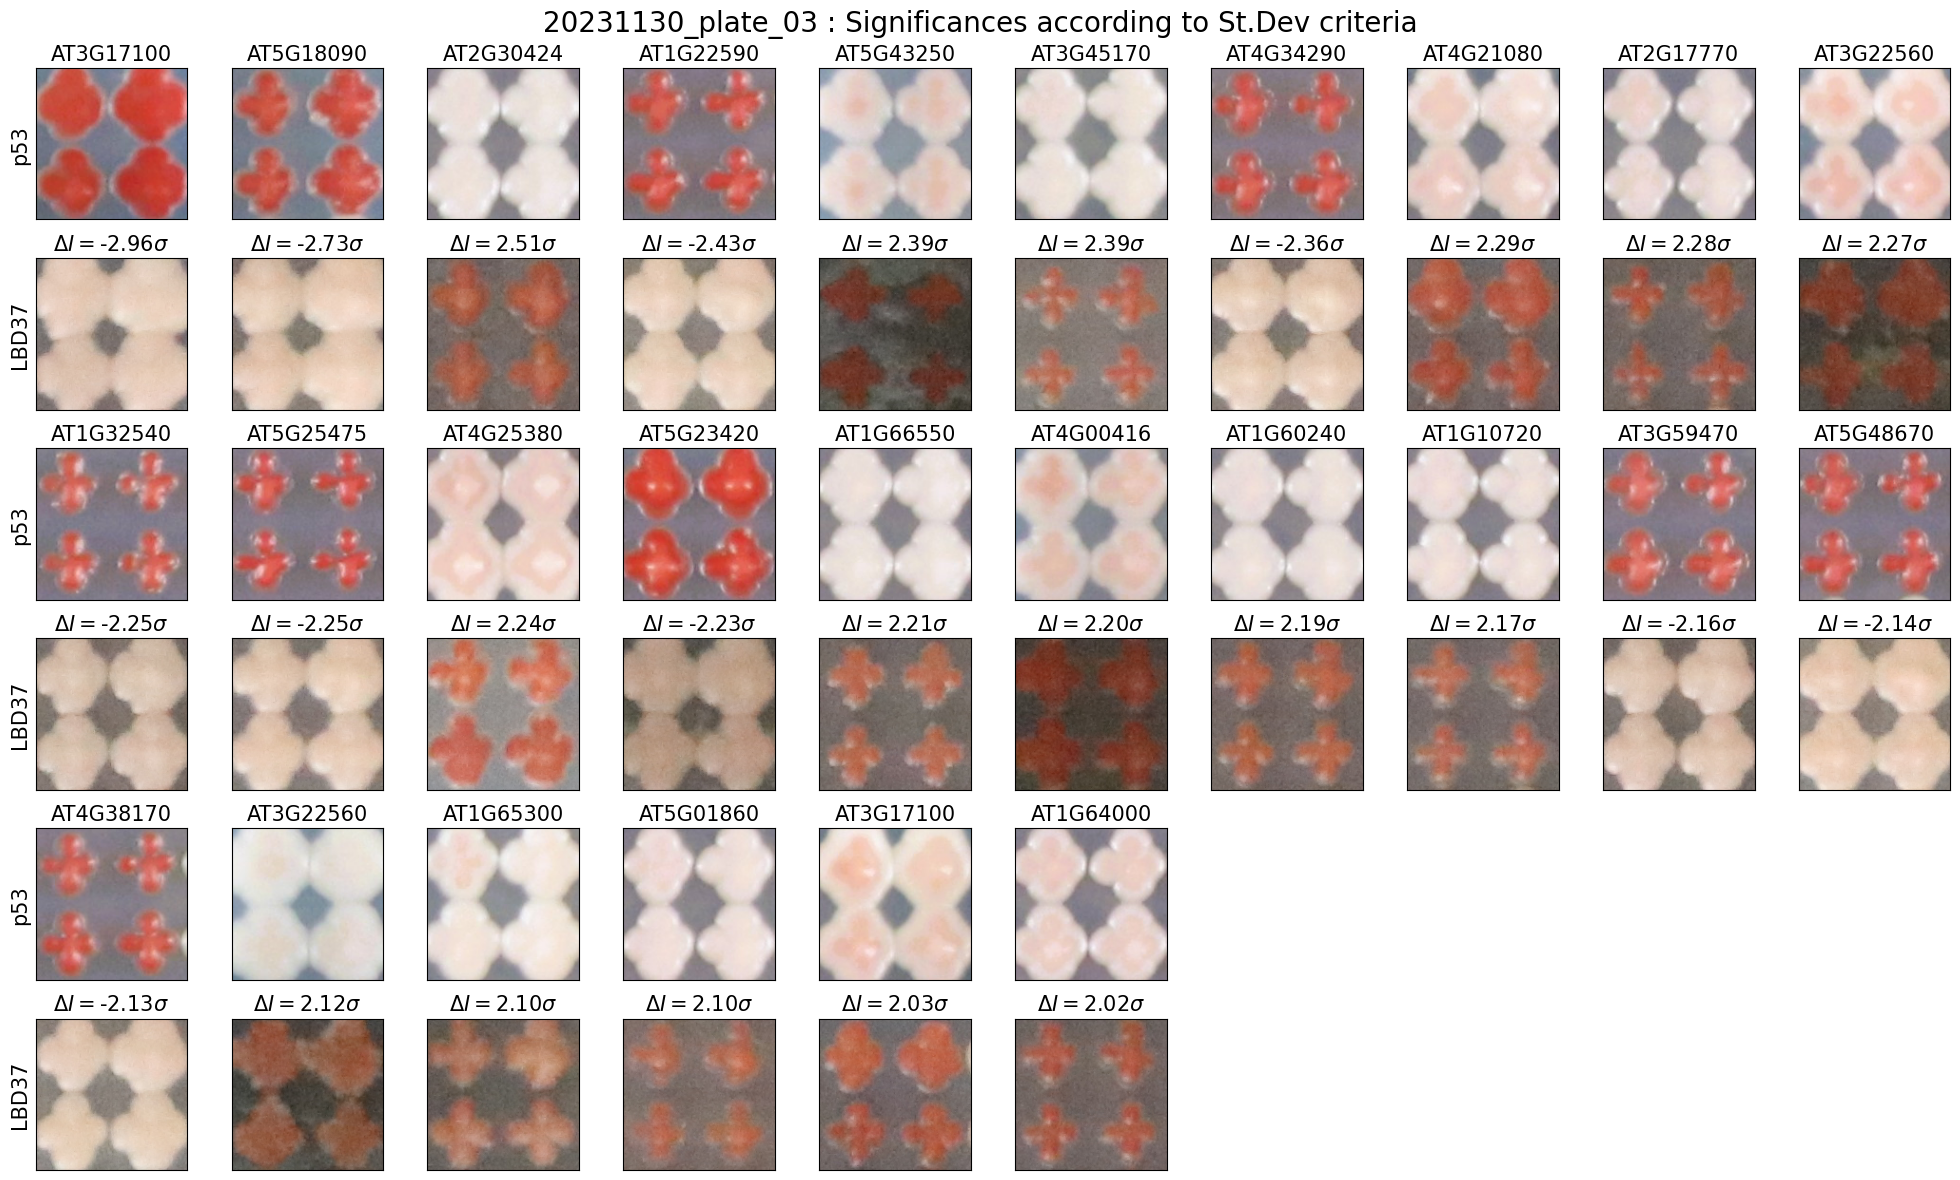

In [23]:
axrows = min([4, len(ssignif)//axcolmax + 1])
axcols = min([axcolmax, len(ssignif)])
plotnums = min([axrows*axcolmax, len(ssignif)])

fig, ax = plt.subplots(2*axrows, axcols, figsize=(figR*axcols-1, 2*figR*axrows), sharex=True, sharey=True)
ax = ax.reshape(2*axrows, axcols)

for i in range(plotnums):
    ix, jx = i//axcols, i%axcols
    ax[2*ix, jx].set_title(ssignif.iloc[i,0], fontsize=fs)
    ax[2*ix+1, jx].set_title('$\Delta I =${:.2f}$\\sigma$'.format(ssignif.iloc[i,7]), fontsize=fs)

    row, col = [int(foo[1:])-1 for foo in ssignif.iloc[i,1].split('-')[1:] ] 

    j = 2*ix
    for (cc,img) in zip([rawcoords, pltcoords],[rawimg,pltimg]):
        dots = cc[2*row : 2*row + 2, 2*col : 2*col + 2]
        center = np.mean(np.mean(dots, axis = 0), axis = 0).astype(int)
        rss = np.s_[center[1] - R : center[1] + R, center[0] - R : center[0] + R]
        ax[j,jx].imshow(img[rss], vmin=0, origin='upper'); j+=1

for i in range(1, 1 + axrows*axcols - plotnums):
    fig.delaxes(ax[-1, -i])
    fig.delaxes(ax[-2, -i])

for i in range(axrows):
    ax[2*i,0].set_ylabel(reference_gene, fontsize=fs)
    ax[2*i + 1,0].set_ylabel(genes[gidx], fontsize=fs)

for a in ax.ravel():
    a.tick_params(bottom=False, left=False, labelbottom=False, labelleft=False)

fig.suptitle(bname + ' : Significances according to St.Dev criteria', fontsize=fs+5)
fig.tight_layout()
filename = ddst + sbname + '.jpg'
print('Generate image', filename)
#plt.savefig(filename, dpi=72, format='jpg', bbox_inches='tight', pil_kwargs={'optimize':True})

Generate image ../diagnostic/leyre/LBD37/p53_vs_20231130_plate_03_laplace_significant.jpg


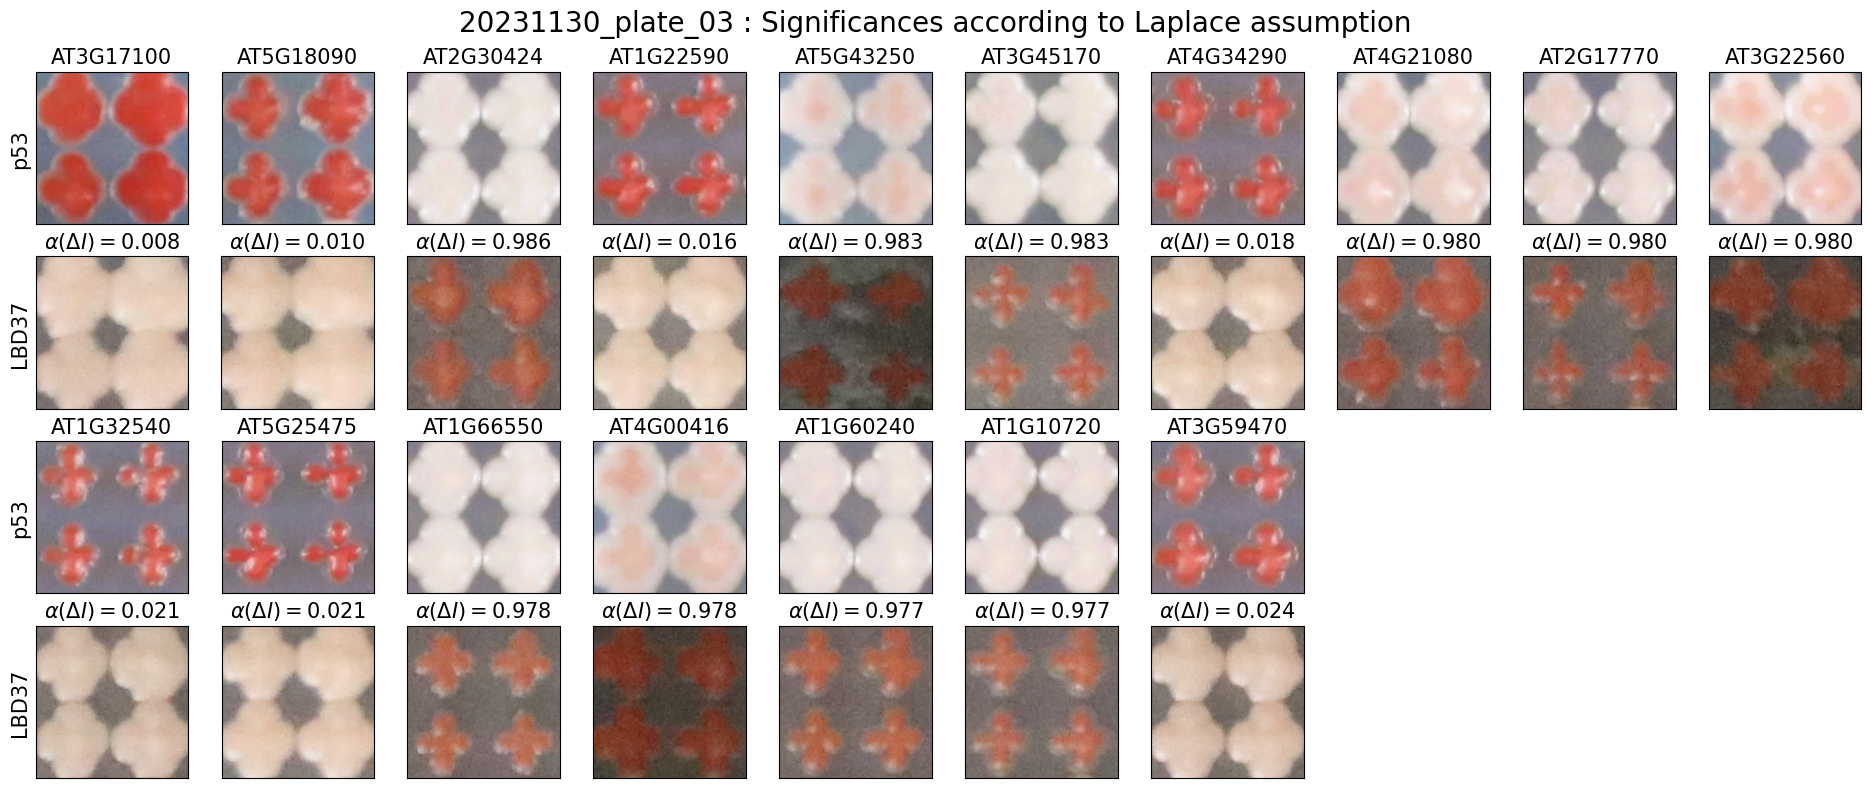

In [27]:
axrows = min([4, len(lsignif)//axcolmax + 1])
axcols = min([axcolmax, len(lsignif)])
plotnums = min([axrows*axcolmax, len(lsignif)])

fig, ax = plt.subplots(2*axrows, axcols, figsize=(figR*axcols-1, 2*figR*axrows), sharex=True, sharey=True)
ax = ax.reshape(2*axrows, axcols)

for i in range(plotnums):
    ix, jx = i//axcols, i%axcols
    ax[2*ix, jx].set_title(lsignif.iloc[i,0], fontsize=fs)
    ax[2*ix+1, jx].set_title('$\\alpha(\\Delta I) =${:.3f}'.format(lsignif.iloc[i,8]), fontsize=fs)

    row, col = [int(foo[1:])-1 for foo in lsignif.iloc[i,1].split('-')[1:] ] 

    j = 2*ix
    for (cc,img) in zip([rawcoords, pltcoords],[rawimg,pltimg]):
        dots = cc[2*row : 2*row + 2, 2*col : 2*col + 2]
        center = np.mean(np.mean(dots, axis = 0), axis = 0).astype(int)
        rss = np.s_[center[1] - R : center[1] + R, center[0] - R : center[0] + R]
        ax[j,jx].imshow(img[rss], vmin=0, origin='upper'); j+=1

for i in range(1, 1 + axrows*axcols - plotnums):
    fig.delaxes(ax[-1, -i])
    fig.delaxes(ax[-2, -i])

for i in range(axrows):
    ax[2*i,0].set_ylabel(reference_gene, fontsize=fs)
    ax[2*i + 1,0].set_ylabel(genes[gidx], fontsize=fs)

for a in ax.ravel():
    a.tick_params(bottom=False, left=False, labelbottom=False, labelleft=False)

fig.suptitle(bname + ' : Significances according to Laplace assumption', fontsize=fs+5)
fig.tight_layout()
filename = ddst + lbname + '.jpg'
print('Generate image', filename)
#plt.savefig(filename, dpi=72, format='jpg', bbox_inches='tight', pil_kwargs={'optimize':True})